<a href="https://colab.research.google.com/github/ShengwenWesley/QAIFS_Stack/blob/main/QAIFS_Onboarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librares

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# Data Preprocessing

### Input Data

As the first on boarding project, only open,close and volume data for the past 6 months were used. The closing price and volume are used to predict the opening price of the next day, so that they were shifted by -1 upwards.

In [ ]:
dat = yf.Ticker("AAPL")
rawData = dat.history(period="6mo")[['Open','Close','Volume']]
rawData['Close'] = rawData['Close'].shift(-1)
rawData['Volume'] = rawData['Volume'].shift(-1)
rawData = rawData.iloc[:len(rawData)-1,]

### Normalization

All data are normalized by <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**$x = \frac{x - mean}{std}$**

In [ ]:
closePriceMean = rawData['Close'].mean()
closePriceStd = rawData['Close'].std()
rawData['Close'] -= closePriceMean
rawData['Close'] /= closePriceStd

openPriceMean = rawData['Open'].mean()
openPriceStd = rawData['Open'].std()
rawData['Open'] -= openPriceMean
rawData['Open'] /= openPriceStd

volumMean = rawData['Volume'].mean()
volumStd = rawData['Volume'].std()
rawData['Volume'] -= volumMean
rawData['Volume'] /= volumStd

rawData['time'] = np.arange(1,len(rawData)+1)

processedData = rawData[['Open','Close','Volume','time']].to_numpy()
processedData.shape

(125, 4)

### Preparing DataSet

Note:DataLoader are not used here since shuffling and batch training are not employed.

In [ ]:
trainingData = processedData[:int(len(processedData)*0.8),]
testingData = processedData[int(len(processedData)*0.8):,]
class myData(Dataset):
    def __init__(self,data):
        self.data = data
    def __getitem__(self,index):
        lastClose,lastVolume,time,open = self.data[index,1],self.data[index,2],self.data[index,3],self.data[index,0]
        feature = torch.tensor([lastClose,lastVolume,time],dtype=torch.float32)
        label = torch.tensor(open,dtype=torch.float32)
        return feature,label
    def __len__(self):
        return len(self.data)
trainingData = myData(trainingData)
testingData = myData(testingData)

# Model Training


### Define Model

I decided to use MultiLayer Perceptrons in this case. The two activation functions are commented because here I only need layers to do simple feature engineering while non-linear activation functions would lead to loss of information from the limited number of features.

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(3,25),
        # nn.Tanh(),
        nn.Linear(25,5),
        # nn.Tanhshrink(),
        nn.Linear(5,1)
    )
  def forward(self,X):
    return self.model(X)

### Define the training function

Mean Square Error and Adam Optimizer are used here. **DON'T FORGET TO ZERO_GRAD.**  

In [ ]:
cumulativeLoss = []
def training(model,epochs):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())
  for epoch in range(epochs):
    curEpochLoss = 0
    for i in range(len(trainingData)):
      feature,label = trainingData[i]

      y_pred = model(feature)
      loss = criterion(y_pred,label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      curEpochLoss += loss.item()

    cumulativeLoss.append(curEpochLoss / len(trainingData))
    print("Epochs: %d ... Loss: %.3f",epoch,curEpochLoss / len(trainingData))

### Training

The model are trained by 50 epoches and loss are plotted.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: %d ... Loss: %.3f 0 0.4023132922090008
Epochs: %d ... Loss: %.3f 1 0.5614563717629062
Epochs: %d ... Loss: %.3f 2 0.5182488075242145
Epochs: %d ... Loss: %.3f 3 0.5634465128113516
Epochs: %d ... Loss: %.3f 4 0.5768121622141916
Epochs: %d ... Loss: %.3f 5 0.4948448008201376
Epochs: %d ... Loss: %.3f 6 0.4759446626161662
Epochs: %d ... Loss: %.3f 7 0.5028834488167194
Epochs: %d ... Loss: %.3f 8 0.6005302940896945
Epochs: %d ... Loss: %.3f 9 0.7607717663713265
Epochs: %d ... Loss: %.3f 10 0.6574202441863599
Epochs: %d ... Loss: %.3f 11 0.4394327928530765
Epochs: %d ... Loss: %.3f 12 0.33436809403137885
Epochs: %d ... Loss: %.3f 13 0.34694593199878
Epochs: %d ... Loss: %.3f 14 0.2889866318559507
Epochs: %d ... Loss: %.3f 15 0.25927153739532516
Epochs: %d ... Loss: %.3f 16 0.2298597252408217
Epochs: %d ... Loss: %.3f 17 0.20731826022929453
Epochs: %d ... Loss: %.3f 18 0.18912781930300768
Epochs: %d ... Loss: %.3f 19 0.17798851999469206
Epochs: %d ... Loss: %.3f 20 0.1707266029182471

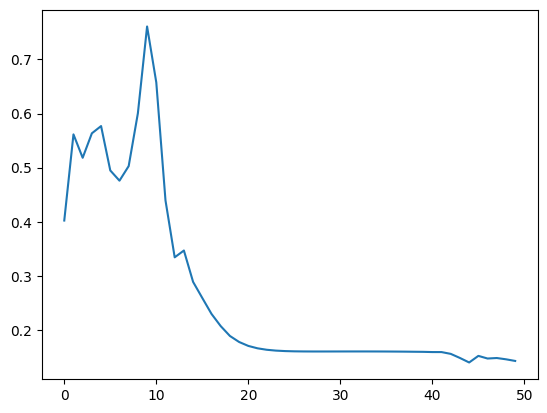

In [ ]:
myMLP = MLP()
training(myMLP,50)
plt.figure()
plt.plot(np.arange(len(cumulativeLoss)),cumulativeLoss)
plt.show()

# Inference

Here model are used to predict future data, the loss over time are plotted in the second block. It could be inferred that some holiday effect appeared at the peak error for any changed to MLP architecture would all capture this error. Feel free to change to MLP architecture and retrain.

In [ ]:
myMLP.eval()
criterion = nn.MSELoss()
predictedData = []
testingLoss = []
for feature,label in testingData:
  y_pred = myMLP(feature)
  predictedData.append(y_pred.item())
  loss = criterion(y_pred,label)
  testingLoss.append(loss.item())

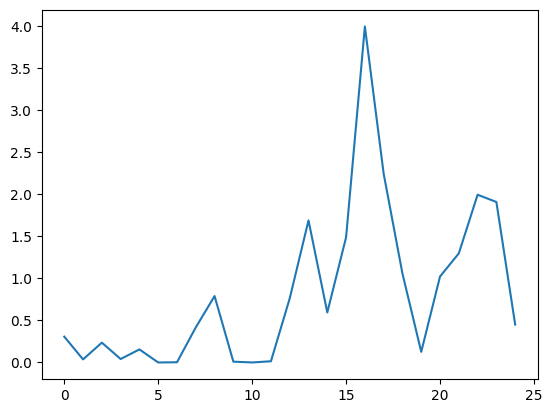

In [ ]:
plt.figure()
plt.plot(np.arange(len(testingLoss)),testingLoss)
plt.show()

# Performance

Normalized predictions are mapped back to real predicted opening prices, the result is plotted.

In [ ]:
realData = processedData[int(len(processedData)*0.8):,]
realData = realData[:,0]*openPriceStd+openPriceMean
predictedData = np.array(predictedData)*openPriceStd+openPriceMean

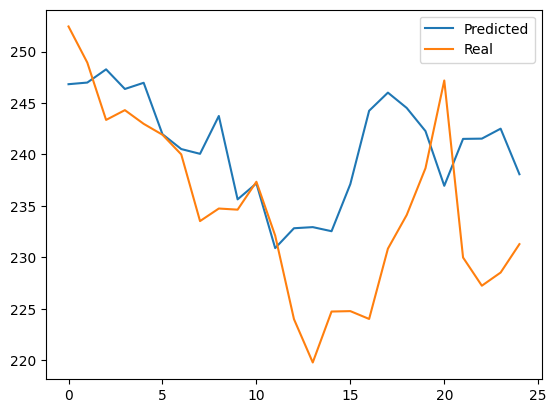

In [ ]:
plt.figure()
plt.plot(np.arange(len(testingLoss)),predictedData,label="Predicted")
plt.plot(np.arange(len(testingLoss)),realData,label="Real")
plt.legend()
plt.show()